In [1]:
"""
TODO: feed in actual dataset and see how it performs
"""


"""
https://heartbeat.fritz.ai/transfer-learning-with-pytorch-cfcb69016c72
"""
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
from torchvision import datasets, transforms, models #need to do: pip install pillow==6.1
from PIL import Image
import numpy as np
import os
from torch.utils.data.sampler import SubsetRandomSampler
import pandas as pd


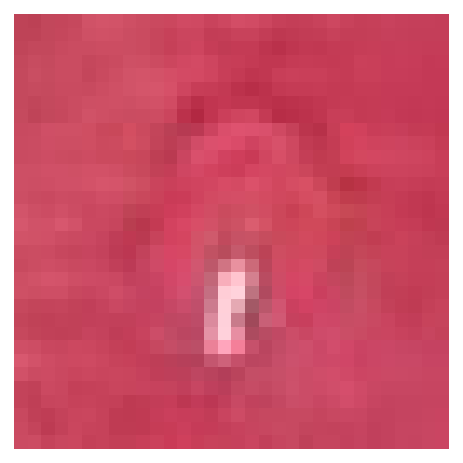

In [2]:
img_dir = 'image_jessie/dataset_tongue'
def imshow(image):
#     plt.figure(figsize=(1,1))
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
#example image
x=Image.open(img_dir+'/no/000001.png')
np.array(x).shape
imshow(x)

In [3]:
# Define transforms for the training, validation, and testing sets
# data augmentation: randomly crop, resize, and rotate the images so that 
# for each epoch (one pass through the dataset) ----?!?!?!?!?!?!?!?!?!?!?!?, the network sees different variations 
# of the same image.This will eventually lead to better accuracy on the validation tests.
train_transforms = transforms.Compose([transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
                                      transforms.RandomRotation(degrees=15),
                                      transforms.ColorJitter(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.CenterCrop(size=224),  # Image net standards
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])
                                      ])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])

In [4]:
#Loading in the dataset

train_data = datasets.ImageFolder(img_dir,transform=train_transforms)
# number of subprocesses to use for data loading
num_workers = 0
# percentage of training set to use as validation and testing
valid_size = 0.2
test_size = 0.1

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
valid_split = int(np.floor((valid_size) * num_train))
test_split = int(np.floor((valid_size+test_size) * num_train))
valid_idx, test_idx, train_idx = indices[:valid_split], indices[valid_split:test_split], indices[test_split:]

print(len(valid_idx), len(test_idx), len(train_idx))

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=32, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(train_data, batch_size=32, 
    sampler=test_sampler, num_workers=num_workers)


90 45 315


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#pretrained=True will download a pretrained network for us
model = models.densenet121(pretrained=True)
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [6]:
#Freeze model parameters
for param in model.parameters():
  param.require_grad = False

# define our model as a sequence of layers. nn.Sequential is a Module which contains 
# other Modules, and applies them in sequence toproduce its output. 
# Each Linear Module computes output from input using a linear function, 
# and holds internal Tensors for its weight and bias.

#input dimention: 1024, hidden dimention: 460, output dimention: 2
fc = nn.Sequential(
    nn.Linear(1024, 460), 
    nn.ReLU(),
    nn.Dropout(0.4),
    
    nn.Linear(460,2),
    nn.LogSoftmax(dim=1)
    
)
model.classifier = fc

# loss function: CrossEntropyLoss
# criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()

# optimizer
# we only want to update the parameters of the classifier
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.003)
# optimizer = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [7]:
#Training the model and saving checkpoints of best performances. That is lower validation loss and higher accuracy
epochs = 10
valid_loss_min = np.Inf
import time
for epoch in range(epochs):
    start = time.time()
    model.train()
    train_loss = 0.0
    valid_loss = 0.0
    for inputs, labels in train_loader:       
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)        
        optimizer.zero_grad()        
        logps = model(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
       
    model.eval()
    
    with torch.no_grad():
        accuracy = 0
        for inputs, labels in valid_loader:            
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels)
            valid_loss += batch_loss.item()
            
            # Calculate accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            
            
    # calculate average losses
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)
    valid_accuracy = accuracy/len(valid_loader) 
      
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(
        epoch + 1, train_loss, valid_loss, valid_accuracy))
            
    if valid_loss <= valid_loss_min:      
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
        torch.save(model.state_dict(), 'model_tongue.pt')
        valid_loss_min = valid_loss        

Epoch: 1 	Training Loss: 1.055133 	Validation Loss: 0.649537 	Validation Accuracy: 0.590545
Validation loss decreased (inf --> 0.649537).  Saving model ...
Epoch: 2 	Training Loss: 0.625069 	Validation Loss: 0.604542 	Validation Accuracy: 0.689103
Validation loss decreased (0.649537 --> 0.604542).  Saving model ...
Epoch: 3 	Training Loss: 0.563861 	Validation Loss: 0.553989 	Validation Accuracy: 0.787660
Validation loss decreased (0.604542 --> 0.553989).  Saving model ...
Epoch: 4 	Training Loss: 0.579944 	Validation Loss: 0.589349 	Validation Accuracy: 0.692308
Epoch: 5 	Training Loss: 0.607914 	Validation Loss: 0.739349 	Validation Accuracy: 0.572917
Epoch: 6 	Training Loss: 0.507339 	Validation Loss: 0.549894 	Validation Accuracy: 0.727564
Validation loss decreased (0.553989 --> 0.549894).  Saving model ...
Epoch: 7 	Training Loss: 0.422958 	Validation Loss: 0.537653 	Validation Accuracy: 0.777244
Validation loss decreased (0.549894 --> 0.537653).  Saving model ...
Epoch: 8 	Traini

In [16]:
#Loading the saved model from disk
model.load_state_dict(torch.load('model_tongue.pt'))

#Testing loaded model on unseen data
def test(model, criterion):
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    for batch_idx, (data, target) in enumerate(test_loader):
        # move to GPU
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
    
    print('Test Loss: {:.6f}\n'.format(test_loss))
    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))

test(model, criterion)

Test Loss: 0.431367


Test Accuracy: 80% (36/45)


In [17]:
def load_input_image(img_path):    
    image = Image.open(img_path)
    prediction_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                     transforms.ToTensor(), 
                                     transforms.Normalize([0.485, 0.456, 0.406], 
                                                          [0.229, 0.224, 0.225])])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = prediction_transform(image)[:3,:,:].unsqueeze(0)
    return image

def predict_kawasaki(model, class_names, img_path):
    # load the image and return the predicted breed
    img = load_input_image(img_path)
    model = model.cpu()
    model.eval()
    idx = torch.argmax(model(img))
    return class_names[idx]


Not Kawasaki


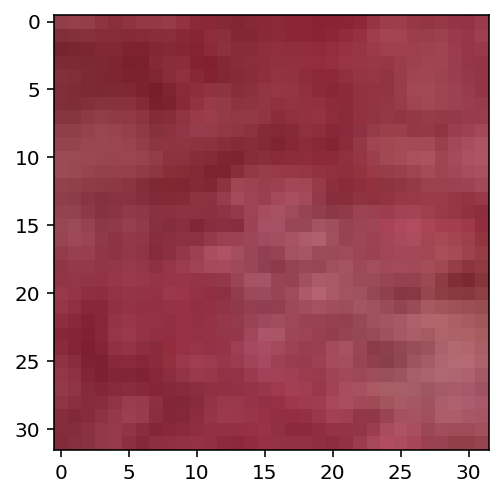

Not Kawasaki


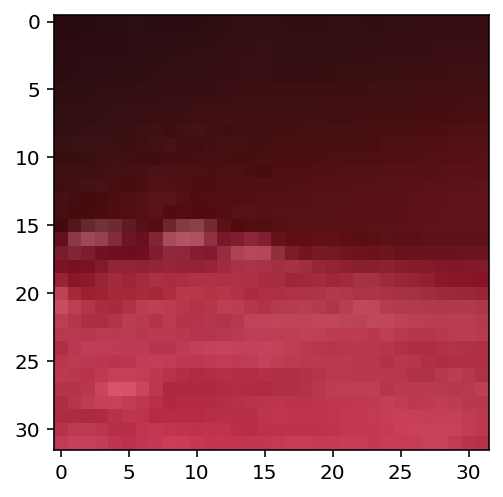

Not Kawasaki


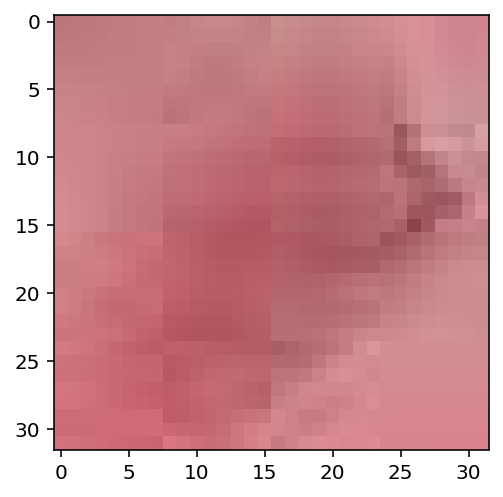

------------------------------------------------------
Kawasaki


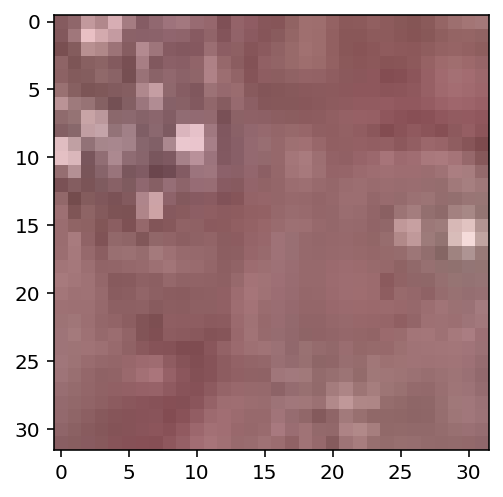

Kawasaki


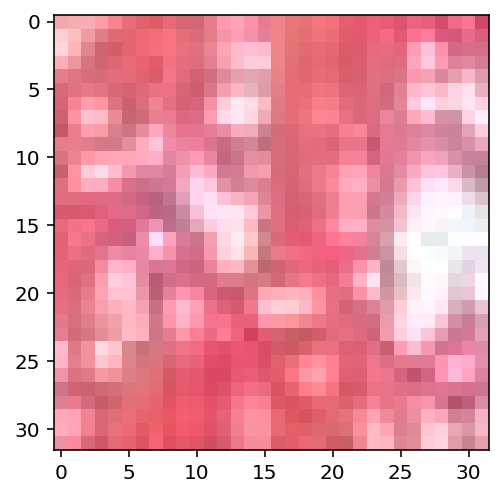

Kawasaki


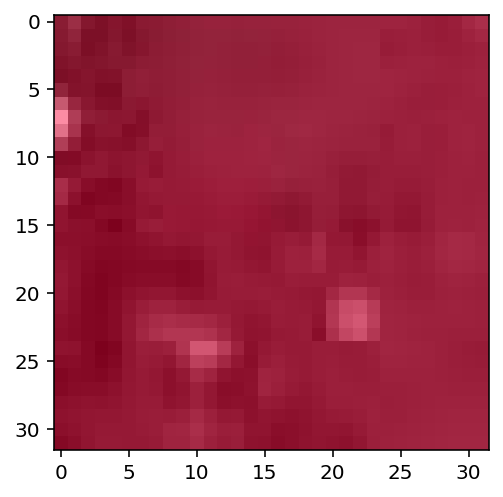

In [27]:
from glob import glob
from PIL import Image
from termcolor import colored

class_names=['no','yes']
img_dir = 'image_jessie/dataset_tongue'
notkawa = np.array(glob(img_dir + "/no/*"))
kawa = np.array(glob(img_dir + "/yes/*"))

# color green means the model predicted correctly
# range can be chosen arbitrarily as long as it stays in bound
for i in range(15,105,30):
    img_path=notkawa[i]
    img = Image.open(img_path)
    if predict_kawasaki(model, class_names, img_path) == 'no':
        print(colored('Not Kawasaki', 'green'))
    else:
        print(colored('Kawasaki', 'red'))
    plt.imshow(img)
    plt.show()

print("------------------------------------------------------")
    
for i in range(13,103,30):
    img_path=kawa[i]
    img = Image.open(img_path)
    if predict_kawasaki(model, class_names, img_path) == 'yes':
        print(colored('Kawasaki', 'green'))
    else:
        print(colored('Not Kawasaki', 'red'))      
    plt.imshow(img)
    plt.show()